In [1]:
import os
from copy import deepcopy

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

from src.data import generate_data, get_promt, random_sample_data
from src.transformer import Transformer_F, in_context_loss, clip_and_step
from src.utils import get_device
from src.theory import OptParamGenerator

matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams.update({"font.size": 18})
legend_fontsize = 14


def plot_mean_std(ax, loss_list, *, label=None, lw=3, xs=None, stride=None, marker=False, markersize=4):
    losses = torch.stack(loss_list)
    if xs is None:
        xs = torch.arange(losses.shape[1], dtype=torch.float) * stride
    xs_np = xs.detach().cpu().numpy() if torch.is_tensor(xs) else xs
    mean = torch.mean(losses, dim=0).detach().cpu().numpy()
    std = torch.std(losses, dim=0).detach().cpu().numpy()
    if marker:
        ax.plot(xs_np, mean, lw=lw, label=label, marker='o', markersize=markersize)
    else:
        ax.plot(xs_np, mean, lw=lw, label=label)
    ax.fill_between(xs_np, mean - std, mean + std, alpha=0.2)
    return xs_np, mean, std


In [ ]:
device = get_device("cuda")
train_seed = 0
test_seeds = list(range(5))

# model / algorithm
n_head = 1
n_layer = 1
alg = "sgd"

lr_pt = 0.01
lr_ft = 0.01

max_iters_pt = 5000
max_iters_ft = 5000

# data
B_pt = 5000
B_ft = 5000
N_pt = 20
N_ft = 20
dataset_size_ft = 100_000
d = 5
x_std = 1.0
noise_std = np.sqrt(0.1)

a = N_pt/(N_pt+1+d)
print( d*a/(2-a) * (1+noise_std**2/x_std/1) - 1 )

2.4375000000000004


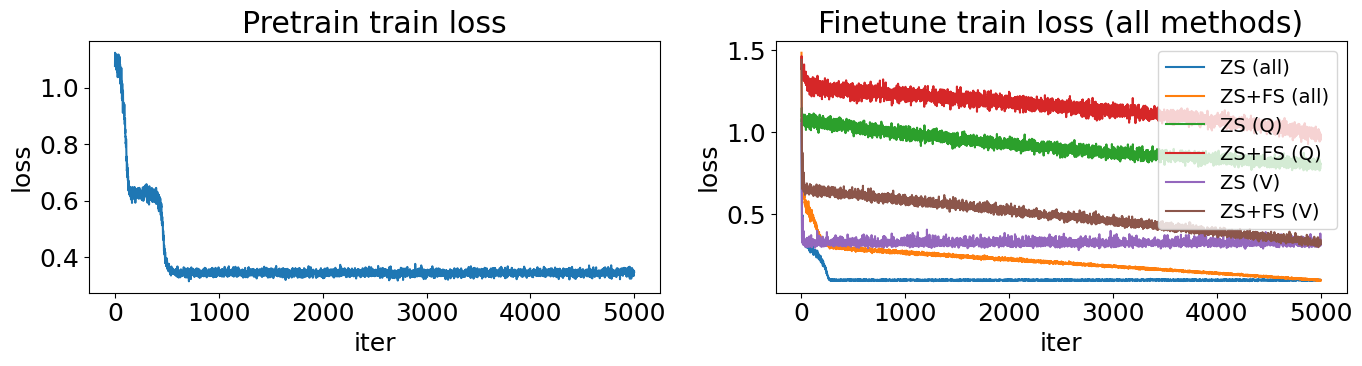

In [ ]:
ft_methods = ["zs", "both", "zs_kq", "both_kq", "zs_v", "both_v"]

labels = {
    "zs": "ZS (all)", "both": "ZS+FS (all)",
    "zs_kq": "ZS (Q)", "both_kq": "ZS+FS (Q)",
    "zs_v": "ZS (V)", "both_v": "ZS+FS (V)",
}

# Logging
log_dict = {
    "pretrain": {"params": [], "loss": []},
    "finetune": {},  # finetune[ft_method] = {"params": [], "loss": [], "zs_loss": [], "fs_loss": []}
    "theta": None,
}

def build_optimizer(alg: str, parameters, lr: float):
    if alg == "sgd":
        return torch.optim.SGD(parameters, lr=lr, momentum=0.9, weight_decay=0.0)
    if alg == "adam":
        return torch.optim.Adam(parameters, lr=lr, betas=(0.9, 0.9), weight_decay=0.0)
    raise ValueError("alg must be 'sgd' or 'adam'")


# 1. Pretraining
torch.manual_seed(train_seed)

model_pretrained = Transformer_F(n_layer, n_head, d).to(device)
optimizer = build_optimizer(alg, model_pretrained.parameters(), lr_pt)

for t in range(max_iters_pt):
    z, y_test = generate_data(
        B_pt, N_pt + 1, d,
        x_std=x_std, noise_std=noise_std, use_prompt=True, device=device
    )
    loss = in_context_loss(model_pretrained, z, y_test)

    log_dict["pretrain"]["loss"].append(loss.item())

    loss.backward()
    norms = clip_and_step(model_pretrained, optimizer, True)
    optimizer.zero_grad()
    log_dict["pretrain"]["params"].append(model_pretrained.allparam.detach().clone())

# 2. Fine-tuning
theta = torch.randn(d, device=device)
theta = theta / theta.norm().clamp_min(1e-12)
log_dict["theta"] = theta.detach()

for ft_method in ft_methods:
    # init per-method logs
    log_dict["finetune"][ft_method] = {
        "params": [],
        "loss": [],
        "zs_loss": [],
        "fs_loss": [],
    }

    model = deepcopy(model_pretrained)

    if "_" in ft_method:
        ft_method_loss, ft_method_suffix = ft_method.split("_", 1)
        if ft_method_suffix == "kq":
            model.q_matrix.requires_grad_(True)
            model.v_matrix.requires_grad_(False)
        elif ft_method_suffix == "v":
            model.q_matrix.requires_grad_(False)
            model.v_matrix.requires_grad_(True)
    else:
        ft_method_loss = ft_method

    optimizer = build_optimizer(alg, model.parameters(), lr_ft)

    x_dataset_ft, y_dataset_ft = generate_data(
        1, dataset_size_ft, d,
        theta=theta, x_std=x_std, noise_std=noise_std, device=device
    )
    x_dataset_ft, y_dataset_ft = x_dataset_ft.squeeze(0), y_dataset_ft.squeeze(0)

    for t in range(max_iters_ft):
        x, y = random_sample_data(x_dataset_ft, y_dataset_ft, B_ft, N_ft + 1, device=device)
        z_context, y_test = get_promt(x, y)
        z = z_context[:, [-1], :]

        zs_loss = in_context_loss(model, z, y_test)
        fs_loss, temp_loss_weight = zs_loss, 0.0

        if ft_method_loss == "zs":
            loss = zs_loss
        elif ft_method_loss == "both":
            fs_loss = in_context_loss(model, z_context, y_test)
            temp_loss_weight = (max_iters_ft - 1 - t) / (max_iters_ft - 1)

            loss = zs_loss + temp_loss_weight * fs_loss
        else:
            raise ValueError("ft_method should be 'zs' or 'both'")

        log_dict["finetune"][ft_method]["loss"].append(loss.item())
        log_dict["finetune"][ft_method]["zs_loss"].append(zs_loss.item())
        log_dict["finetune"][ft_method]["fs_loss"].append(fs_loss.item())

        loss.backward()
        norms = clip_and_step(model, optimizer, True)
        optimizer.zero_grad()
        log_dict["finetune"][ft_method]["params"].append(model.allparam.detach().clone())

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(log_dict["pretrain"]["loss"])
axs[0].set_title("Pretrain train loss")
axs[0].set_xlabel("iter")
axs[0].set_ylabel("loss")

for ft_method in ft_methods:
    axs[1].plot(log_dict["finetune"][ft_method]["loss"], label=labels[ft_method])

axs[1].set_title("Finetune train loss (all methods)")
axs[1].set_xlabel("iter")
axs[1].set_ylabel("loss")
axs[1].legend(fontsize=legend_fontsize)

plt.tight_layout()
plt.show()


In [ ]:
B_eval = 50000

N_list  = list(range(0, 21))
plot_methods = ["pretrained", "zs", "zs_kq", "zs_v", "both", "both_kq", "both_v"]

cnt_zs = 0.52
cnt_zs_v = N_pt / (N_pt+1+d) # 0.77
cnt_both_v = 0.66
theta0 = log_dict["theta"].to(device).detach()
gen = OptParamGenerator(d, device)

model_eval = Transformer_F(n_layer, n_head, d).to(device)

results = {}
for method in plot_methods:
    # theory-derived parameters
    if method == "pretrained":
        theory_params = gen.opt_params(model_eval, "pretrain", m=N_pt)
    elif method == "zs":
        theory_params = gen.opt_params(model_eval, "zs_finetune", theta0=theta0, cnt=cnt_zs)
    elif method == "zs_v":
        theory_params = gen.opt_params(model_eval, "zs_finetune_v_only", theta0=theta0, cnt=cnt_zs_v)
    elif method == "both_v":
        theory_params = gen.opt_params(model_eval, "zs_finetune_v_only", theta0=theta0, cnt=cnt_both_v)

    # learned params
    learned_params = (
        log_dict["pretrain"]["params"][-1]
        if method == "pretrained"
        else log_dict["finetune"][method]["params"][-1]
    )

    results[method] = {
        "theory_pos": [],
        "theory_neg": [],
        "learned_pos": [],
        "learned_neg": [],
    }

    for tag, params in [("theory", theory_params), ("learned", learned_params)]:
        with torch.no_grad():
            model_eval.allparam = params

        for seed in test_seeds:
            torch.manual_seed(seed)
            pos_vals, neg_vals = [], []

            for N in N_list:
                z, y = generate_data(
                    B_eval, N + 1, d, theta=theta0,
                    x_std=x_std, noise_std=noise_std, use_prompt=True, device=device
                )
                with torch.no_grad():
                    pos_vals.append(in_context_loss(model_eval, z, y).item())

                z, y = generate_data(
                    B_eval, N + 1, d, theta=-theta0,
                    x_std=x_std, noise_std=noise_std, use_prompt=True, device=device
                )
                with torch.no_grad():
                    neg_vals.append(in_context_loss(model_eval, z, y).item())

            results[method][f"{tag}_pos"].append(torch.tensor(pos_vals))
            results[method][f"{tag}_neg"].append(torch.tensor(neg_vals))

    # average over seeds
    for k in ["theory_pos", "theory_neg", "learned_pos", "learned_neg"]:
        results[method][k] = torch.stack(results[method][k]).mean(dim=0).cpu().numpy()


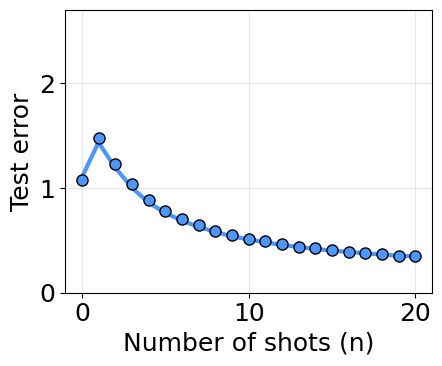

ZS (all)


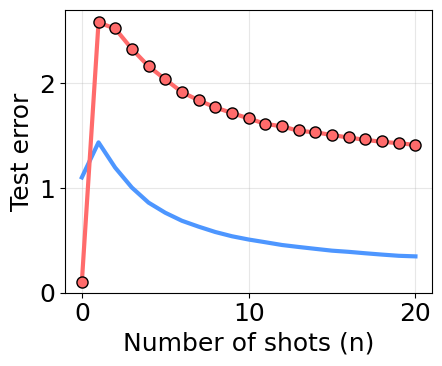

ZS (V)


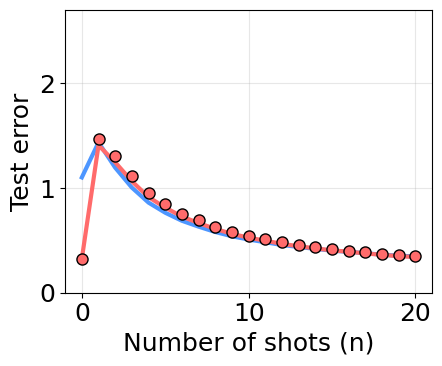

ZS+FS (V)


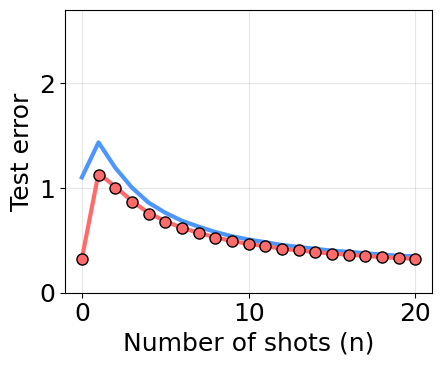

In [5]:
learned_marker_style = {"marker": "o", "lw": 0, "markersize": 8, "markeredgewidth": 1, "markeredgecolor": "black",}
figsize = (5, 4)

# ---------- pretrained ----------
fig, ax = plt.subplots(figsize=figsize)
ax.plot(
    N_list, results["pretrained"]["theory_pos"],
    color="#4D96FF", lw=3,
    label="Pretrained model\n(theory-derived)"
)
ax.plot(
    N_list, results["pretrained"]["learned_pos"],
    color="#4D96FF",
    label="Pretrained model",
    **learned_marker_style
)
ax.set_xlabel("Number of shots (n)")
ax.set_ylabel("Test error")
ax.set_ylim(0.0, 2.7)
# ax.legend(fontsize=legend_fontsize, loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/linear_tf_pretrained.pdf")
plt.show()


# ---------- fine-tuned ----------
for method in ["zs", "zs_v", "both_v"]:
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(N_list, results["pretrained"]["theory_pos"], color="#4D96FF", lw=3, label="Pretrained model")
    ax.plot(N_list, results[method]["theory_pos"], color="#FF6B6B", lw=3, label="Fine-tuned model\n(theory-derived)")
    ax.plot(N_list, results[method]["learned_pos"], color="#FF6B6B", label="Fine-tuned model", **learned_marker_style)
    ax.set_xlabel("Number of shots (n)")
    ax.set_ylabel("Test error")
    ax.set_ylim(0.0, 2.7)
    # ax.legend(fontsize=legend_fontsize, loc="upper right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"figs/linear_tf_{method}.pdf")
    print(labels[method])
    plt.show()

# plot for legend only
fig, ax = plt.subplots(figsize=(18, 3))
ax.plot(1, 1, lw=3, c="#4D96FF", label="Pretrained model (theory-derived)")
ax.plot(1, 1, "o", c="#4D96FF", label="Pretrained model")
ax.plot(1, 1, lw=3, c="#FF6B6B", label="Fine-tuned model (theory-derived)")
ax.plot(1, 1, "o", c="#FF6B6B", label="Fine-tuned model")
ax.legend(ncol=4, fontsize=legend_fontsize, loc="upper center")
fig.canvas.draw()
legend = ax.get_legend()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"figs/linear_tf_legend.pdf", bbox_inches=bbox)
plt.close()
    

/tmp/ipykernel_4064287/1891528687.py:20: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set(yscale="log", ylim=(0, 20))


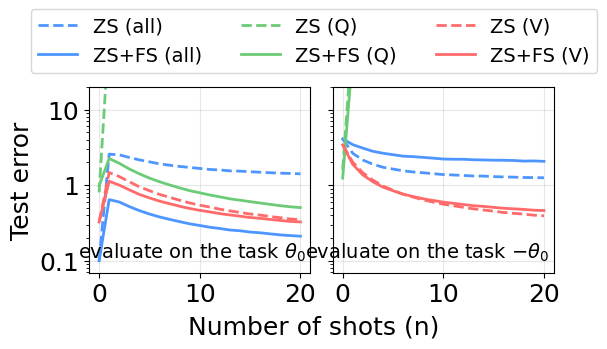

In [9]:
metrics = [("learned_pos", r"$\theta_0$"), ("learned_neg", r"$-\theta_0$")]
ft_methods = ["zs", "both", "zs_kq", "both_kq", "zs_v", "both_v"]

colors = {"full": "#4D96FF", "kq": "#6BCB77", "v": "#FF6B6B"}

def style(m):
    c = colors["kq"] if "kq" in m else colors["v"] if "v" in m else colors["full"]
    return c, ("-" if m.startswith("both") else "--")

fig, axes = plt.subplots(1, 2, figsize=(6, 3.5), sharey=True)
handles = []

for ax, (metric, t) in zip(axes, metrics):
    for m in ft_methods:
        c, ls = style(m)
        ax.plot(N_list, results[m][metric], color=c, linestyle=ls, lw=2)
        if metric == metrics[0][0]:
            handles.append(Line2D([0], [0], color=c, linestyle=ls, lw=2))

    ax.set(yscale="log", ylim=(0, 20))
    ax.set_xticks([0, 10, 20])
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:g}"))
    ax.grid(alpha=0.3)
    ax.text(0.98, 0.05, rf"evaluate on the task {t}",
            transform=ax.transAxes, ha="right", va="bottom",
            fontsize=legend_fontsize)

axes[0].set_ylabel("Test error")
fig.supxlabel("Number of shots (n)", fontsize=18)

fig.legend(
    handles, [labels[m] for m in ft_methods],
    ncol=3, fontsize=legend_fontsize,
    loc="upper center", bbox_to_anchor=(0.5, 0.98),
)

fig.subplots_adjust(wspace=0.1, top=0.73, bottom=0.2)
fig.savefig(f"figs/linear_tf_thetas.pdf", bbox_inches="tight")
plt.show()


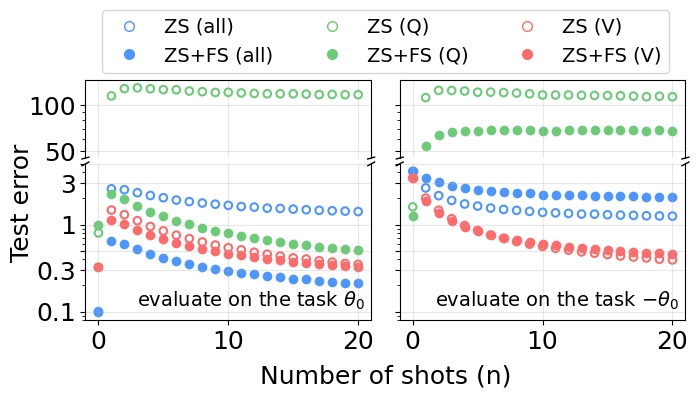

In [10]:

metrics = [("learned_pos", r"$\theta_0$"), ("learned_neg", r"$-\theta_0$")]
ft_methods = ["zs", "both", "zs_kq", "both_kq", "zs_v", "both_v"]
colors = {"full": "#4D96FF", "kq": "#6BCB77", "v": "#FF6B6B"}

def style(m):
    c = colors["kq"] if "kq" in m else colors["v"] if "v" in m else colors["full"]
    return c, m.startswith("both")

# broken ranges
y_bot, y_top = (0.08, 5), (45, 145)
yticks = np.array([0.1, 0.3, 1, 3, 50, 100], dtype=float)  # [CHG]

def yfmt(y, _):  # [CHG]
    return f"{y:g}" if np.any(np.isclose(y, yticks, rtol=0, atol=1e-12)) else ""

fig, ax = plt.subplots(
    2, 2, figsize=(6, 4), sharex="col",
    gridspec_kw={"height_ratios":[1,2], "hspace":0.05, "wspace":0.1}
)
(ax_tl, ax_tr), (ax_bl, ax_br) = ax
tops, bots = [ax_tl, ax_tr], [ax_bl, ax_br]
handles = []

for j, ((metric, t), axt, axb) in enumerate(zip(metrics, tops, bots)):
    for m in ft_methods:
        c, filled = style(m)
        for a in (axt, axb):
            a.scatter(N_list, results[m][metric],
                      facecolors=c if filled else "none",
                      edgecolors=c, linewidths=1.5, s=30)
        if j == 0:
            handles.append(Line2D([0],[0], marker="o",
                                  markerfacecolor=c if filled else "none",
                                  markeredgecolor=c, linestyle="None", markersize=7))

    for a in (axt, axb):
        a.set_yscale("log")
        a.yaxis.set_major_locator(mticker.LogLocator(base=10, subs=(1.0, 3.0, 5.0)))  # [ADD]
        a.yaxis.set_major_formatter(mticker.FuncFormatter(yfmt))
        a.yaxis.set_minor_formatter(mticker.NullFormatter())
        a.grid(alpha=0.3)

    axb.set_ylim(*y_bot); axt.set_ylim(*y_top)
    axt.spines["bottom"].set_visible(False)
    axb.spines["top"].set_visible(False)
    axt.tick_params(labelbottom=False, bottom=False)
    axb.tick_params(top=False)
    axb.set_xticks([0, 10, 20])
    axb.text(0.98, 0.05, rf"evaluate on the task {t}",
             transform=axb.transAxes, ha="right", va="bottom",
             fontsize=legend_fontsize)

# break marks
d = 0.012
kw = dict(color="k", clip_on=False, lw=1)
for axt, axb in zip(tops, bots):
    axt.plot((-d,d),(-d,d), transform=axt.transAxes, **kw)
    axt.plot((1-d,1+d),(-d,d), transform=axt.transAxes, **kw)
    axb.plot((-d,d),(1-d,1+d), transform=axb.transAxes, **kw)
    axb.plot((1-d,1+d),(1-d,1+d), transform=axb.transAxes, **kw)

for a in (ax_tr, ax_br):
    a.tick_params(axis="y", labelleft=False)

ax_bl.set_ylabel("Test error")
ax_bl.yaxis.set_label_coords(-0.18, 0.75)
fig.supxlabel("Number of shots (n)", fontsize=18)
fig.legend(handles, [labels[m] for m in ft_methods], ncol=3, fontsize=legend_fontsize,
           loc="upper center", bbox_to_anchor=(0.5, 0.98))

fig.subplots_adjust(top=0.78, bottom=0.18, left=0, right=1)
fig.savefig("figs/linear_tf_thetas.pdf", bbox_inches="tight")
plt.show()
